In [2]:
import os
import numpy as np
import cv2  # OpenCV for image processing
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from scipy.stats import entropy as scipy_entropy
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc

In [3]:
class LiftingWavelet:
    def __init__(self):
        # Define the lifting filters for the Haar wavelet
        self.predictor = np.array([1, 1]) / 2  # Prediction filter
        self.updater = np.array([1, -1]) / 2    # Update filter

    def forward(self, x):
        """Perform the forward lifting wavelet transform."""
        n = len(x)
        if n % 2 != 0:
            x = np.pad(x, (0, 1), mode='constant')  # Pad with zeros if odd
        
        x_even = x[::2]
        x_odd = x[1::2]

        p = x_even + self.updater[0] * x_odd
        d = x_odd - self.predictor[0] * p

        return p, d

    def inverse(self, p, d):
        """Perform the inverse lifting wavelet transform."""
        x_even = p
        x_odd = d + self.predictor[0] * x_even

        x_reconstructed = np.empty(len(x_even) + len(x_odd))
        x_reconstructed[0::2] = x_even
        x_reconstructed[1::2] = x_odd

        return x_reconstructed


In [4]:
class LiftingWavelet2D:
    def __init__(self):
        self.lifting_wavelet = LiftingWavelet()

    def forward(self, image):
        """Perform the forward 2D lifting wavelet transform."""
        # Pad the image if dimensions are odd
        if image.shape[0] % 2 != 0:
            image = np.pad(image, ((0, 1), (0, 0)), mode='constant')
        if image.shape[1] % 2 != 0:
            image = np.pad(image, ((0, 0), (0, 1)), mode='constant')

        rows, cols = image.shape
        cA = np.zeros((rows // 2, cols // 2))
        cH = np.zeros((rows // 2, cols // 2))
        cV = np.zeros((rows // 2, cols // 2))
        cD = np.zeros((rows // 2, cols // 2))

        # Apply lifting scheme row-wise
        for i in range(rows):
            p, d = self.lifting_wavelet.forward(image[i, :])
            cA[i // 2, :] = p
            cH[i // 2, :] = d

        # Apply lifting scheme column-wise
        for j in range(cols):
            p, d = self.lifting_wavelet.forward(image[:, j])
            cV[:, j // 2] = p
            cD[:, j // 2] = d
        
        return cA, cH, cV, cD
        
    def level_3_transform(self, image):
        """Perform Level 3 2D lifting wavelet transform."""
        cA1, cH1, cV1, cD1 = self.forward(image)
        cA2, cH2, cV2, cD2 = self.forward(cA1)
        cA3, cH3, cV3, cD3 = self.forward(cA2)
        return (cA3, cH1, cV1, cD1), (cA2, cH2, cV2, cD2), (cA1, cH3, cV3, cD3)
    


In [5]:
def load_dataset(dataset_dir):
    X = []
    y = []
    class_labels = os.listdir(dataset_dir)
    
    for label in class_labels:
        label_dir = os.path.join(dataset_dir, label)
        for filename in os.listdir(label_dir):
            img_path = os.path.join(label_dir, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
            if img is None:
                print(f"Warning: {img_path} could not be loaded.")
                continue
            img = cv2.resize(img, (256, 256))  # Resize to 256x256 for consistency
            X.append(img)  # Keep as 2D array
            y.append(class_labels.index(label))  # Get class index

    return np.array(X), np.array(y)



In [6]:
def calculate_features(cA, cH, cV, cD):
    """Calculate mean, standard deviation, and entropy of the coefficients."""
    features = []
    
    for coeff in [cA, cH, cV, cD]:
        mean = np.mean(coeff)
        std_dev = np.std(coeff)
        ent = scipy_entropy(np.histogram(coeff, bins=256, range=(0, 255))[0])
        features.extend([mean, std_dev, ent])
    
    return features

In [7]:
def extract_features(X):
    lw2d = LiftingWavelet2D()
    features = []
    
    for img in X:
        (cA, cH, cV, cD), (cA1,cH1,cV1,cD1), (cA2,cH2,cV2,cD2) = lw2d.level_3_transform(img)  # Perform Level 3 LWT
        
        # Compute ratios of wavelet coefficients
        epsilon = 1e-6  # Avoid division by zero
        ratio_D_H1 = cD  / (cH + epsilon)
        ratio_H_V1 = cH  / (cV + epsilon)
        ratio_D_V1 = cD  / (cV + epsilon)
        ratio_D_H2 = cD1 / (cH1 + epsilon)
        ratio_H_V2 = cH1 / (cV1 + epsilon)
        ratio_D_V2 = cD1 / (cV1 + epsilon)
        ratio_D_H3 = cD2 / (cH2 + epsilon)
        ratio_H_V3 = cH2 / (cV2 + epsilon)
        ratio_D_V3 = cD2 / (cV2 + epsilon)

        mean_ratios = [np.mean(ratio_D_H1), np.mean(ratio_H_V1), np.mean(ratio_D_V1),
                       np.mean(ratio_D_H2), np.mean(ratio_H_V2), np.mean(ratio_D_V2),
                       np.mean(ratio_D_H3), np.mean(ratio_H_V3), np.mean(ratio_D_V3)]

        var_ratios = [np.var(ratio_D_H1), np.var(ratio_H_V1), np.var(ratio_D_V1),
                      np.var(ratio_D_H2), np.var(ratio_H_V2), np.var(ratio_D_V2),
                      np.var(ratio_D_H3), np.var(ratio_H_V3), np.var(ratio_D_V3)]

        std_ratios = [np.std(ratio_D_H1), np.std(ratio_H_V1), np.std(ratio_D_V1),
                      np.std(ratio_D_H2), np.std(ratio_H_V2), np.std(ratio_D_V2),
                      np.std(ratio_D_H3), np.std(ratio_H_V3), np.std(ratio_D_V3)]

        feature_vector = mean_ratios + var_ratios + std_ratios 
        
        features.append(feature_vector)

    return np.array(features)


In [8]:
dataset_dir = 'I:/Project/DATASET'  # Change to your dataset directory
X, y = load_dataset(dataset_dir)


In [9]:
# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 1664
Validation set size: 208
Test set size: 208


In [10]:
# Extract features using Lifting Wavelet Transform
X_train_features = extract_features(X_train)
X_val_features = extract_features(X_val)
X_test_features = extract_features(X_test)

In [11]:
print("NaN values in X_train_features:", np.isnan(X_train_features).sum())
print("Infinity values in X_train_features:", np.isinf(X_train_features).sum())
print("NaN values in X_val_features:", np.isnan(X_val_features).sum())
print("Infinity values in X_val_features:", np.isinf(X_val_features).sum())
print("NaN values in X_test_features:", np.isnan(X_test_features).sum())
print("Infinity values in X_test_features:", np.isinf(X_test_features).sum())

NaN values in X_train_features: 0
Infinity values in X_train_features: 0
NaN values in X_val_features: 0
Infinity values in X_val_features: 0
NaN values in X_test_features: 0
Infinity values in X_test_features: 0


In [12]:
# Clip values if necessary
X_train_features = np.clip(X_train_features, -1e10, 1e10)

In [13]:
# Replace NaN values with the mean of the feature matrix
X_train_features = np.nan_to_num(X_train_features, nan=np.nanmean(X_train_features))

# Replace infinity values with a large number
X_train_features[np.isinf(X_train_features)] = np.nanmax(X_train_features[np.isfinite(X_train_features)])  # Replace with max finite value

In [14]:
# Replace NaN values with the mean of the feature matrix
X_val_features = np.nan_to_num(X_val_features, nan=np.nanmean(X_val_features))
X_test_features = np.nan_to_num(X_test_features, nan=np.nanmean(X_test_features))

# Replace infinity values with a large number
X_val_features[np.isinf(X_val_features)] = np.nanmax(X_val_features[np.isfinite(X_val_features)])
X_test_features[np.isinf(X_test_features)] = np.nanmax(X_test_features[np.isfinite(X_test_features)])

# Clip values if necessary
X_val_features = np.clip(X_val_features, -1e10, 1e10)
X_test_features = np.clip(X_test_features, -1e10, 1e10)

In [15]:
# Apply PCA after feature extraction
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train_features)
X_val_pca = pca.transform(X_val_features)
X_test_pca = pca.transform(X_test_features)

In [16]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_val_scaled = scaler.transform(X_val_features)
X_test_scaled = scaler.transform(X_test_features)

In [17]:
# Train the logistic regression classifier
from sklearn.model_selection import GridSearchCV

# Define the model
clf_logistic = LogisticRegression(solver='liblinear')

# Define the parameter grid
param_grid = {
    'C': [0.1, 0.5, 1, 5, 10],
    'max_iter': [100, 500, 1000, 2000]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(clf_logistic, param_grid, cv=5, scoring='accuracy')

# Fit the model with the best parameters
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Evaluate the best model on the validation set
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy with Best Model: {val_accuracy:.2f}")

Best Parameters: {'C': 5, 'max_iter': 100}
Best Cross-Validation Score: 0.19352907123991464
Validation Accuracy with Best Model: 0.18


In [18]:
# Train the linear classifier Neural ntework CNN
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', random_state=42)
clf.fit(X_train_scaled, y_train)

MLPClassifier(random_state=42)

In [19]:
# Train the linear classifier Support vector machine
from sklearn.svm import SVC

clf = SVC(kernel='poly', degree=3, random_state=42)
clf.fit(X_train_scaled, y_train)

SVC(kernel='poly', random_state=42)

In [20]:
# Train the linear classifier Random forest
clf = RandomForestClassifier(n_estimators=1000, random_state=42)
clf.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [21]:
# Evaluate the model
y_val_pred = clf.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.2f}")

y_test_pred = clf.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

Validation Accuracy: 0.50
Test Accuracy: 0.57


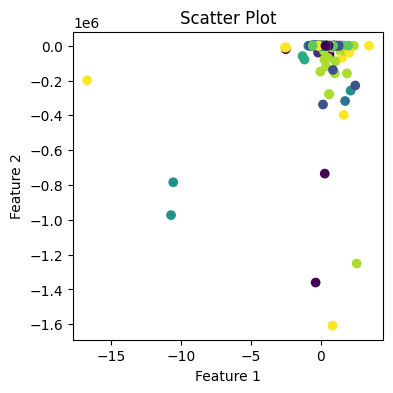

In [22]:
# Plot the scatter matrix
# Plot the scatter plot
plt.figure(figsize=(4,4))
plt.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], c=y_test)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter Plot')
plt.show()

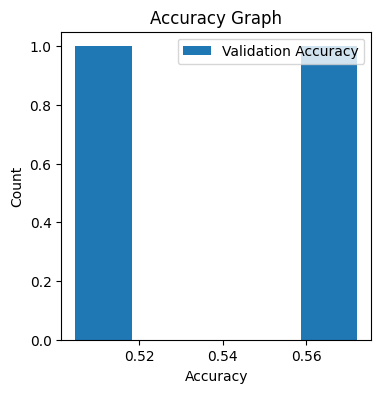

In [23]:
# Plot the accuracy graph
plt.figure(figsize=(4, 4))
plt.hist([val_accuracy, test_accuracy], bins=5, label=['Validation Accuracy', 'Test Accuracy'])
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.title('Accuracy Graph')
plt.legend()
plt.show()

<Figure size 400x400 with 0 Axes>

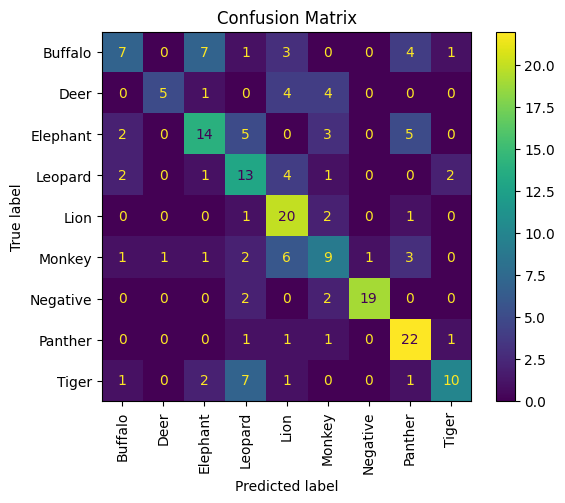

In [25]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm ,display_labels=os.listdir(dataset_dir))
plt.figure(figsize=(4, 4))
disp.plot()
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()